# Topic modeling of NYT Modern Love

Goals:
1. Use clustering to group sentences of articles by topic using k-means with varied number of clusters and LDA

2. Do feature extraction to predict year of article publication using multi layer perceptrons

3. Compare LSA, LDA, and NMF

# Introduction

I wanted to look at some natural language processing to do some topic modeling of New York Times Modern Love columns. I have some urls from 2004 to 2018 and want to group them by topic and then predict what time frame they are from. We can look at the topic groups and see what words are used the most using some cool visuals from pyLDAvis. Next I look at some different clustering, K-means and see how the groupings change was the number of clusters is increased from 5 to 10. Then, I look at multi-layer perceptrons to see if we can predict what period the articles are from. Lastly, we compare LSA, LDA, and NMF to see how the different models group words into topics.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from collections import Counter
import nltk

In [2]:
# I got about 50 articles from 2004 to 2006 and another set of 50 from 2018

import requests
from bs4 import BeautifulSoup

# combine text from multiple urls

urls_list_modern_love = ['https://www.nytimes.com/2005/05/29/fashion/sundaystyles/a-prince-charming-for-the-prom-not-ever-after-though.html',
                        'https://www.nytimes.com/2004/10/31/fashion/just-friends-let-me-read-between-the-lines.html',
                        'https://www.nytimes.com/2005/03/27/fashion/truly-madly-guiltily.html?rref=collection%2Fcolumn%2Fmodern-love&action=click&contentCollection=fashion&region=stream&module=stream_unit&version=search&contentPlacement=4&pgtype=collection',
                        'https://www.nytimes.com/2005/09/11/fashion/sundaystyles/djs-homeless-mommy.html',
                        'https://www.nytimes.com/2006/01/29/fashion/sundaystyles/29LOVE.html',
                        'https://www.nytimes.com/2006/02/26/fashion/sundaystyles/26LOVE.html',
                        'https://www.nytimes.com/2006/05/07/fashion/sundaystyles/07love.html',
                        'https://www.nytimes.com/2006/05/14/fashion/sundaystyles/14love.html',
                        'https://www.nytimes.com/2006/05/21/fashion/sundaystyles/21love.html',
                        
                        'https://www.nytimes.com/2006/05/28/fashion/sundaystyles/28love.html',
                        'https://www.nytimes.com/2006/06/04/fashion/04love.html',
                        'https://www.nytimes.com/2006/06/11/fashion/sundaystyles/11love.html',
                        'https://www.nytimes.com/2006/06/18/fashion/sundaystyles/18love.html',
                        'https://www.nytimes.com/2006/06/25/fashion/25love.html',
                        'https://www.nytimes.com/2006/06/25/fashion/25love.html',
                        'https://www.nytimes.com/2006/07/16/fashion/sundaystyles/16love.html',
                        'https://www.nytimes.com/2006/07/30/fashion/30LOVE.html',
                        'https://www.nytimes.com/2006/08/06/fashion/06love.html',
                        'https://www.nytimes.com/2006/08/13/fashion/13love.html',
                         
                        'https://www.nytimes.com/2006/08/20/fashion/20LOVE.html',
                        'https://www.nytimes.com/2006/08/27/fashion/27love.html',
                        'https://www.nytimes.com/2006/09/03/fashion/03love.html',
                        'https://www.nytimes.com/2006/09/10/fashion/10love.html',
                        'https://www.nytimes.com/2006/09/17/fashion/17love.html',
                        'https://www.nytimes.com/2006/09/24/fashion/24love.html',
                        'https://www.nytimes.com/2006/10/01/fashion/01love.html',
                        'https://www.nytimes.com/2006/10/08/fashion/08love.html',
                        'https://www.nytimes.com/2006/10/15/fashion/15love.html',
                        'https://www.nytimes.com/2006/10/22/fashion/22love.html',
                        
                        'https://www.nytimes.com/2006/10/29/fashion/29love.html',
                        'https://www.nytimes.com/2006/11/05/fashion/05love.html',
                        'https://www.nytimes.com/2006/11/12/fashion/12love.html',
                        'https://www.nytimes.com/2006/11/19/fashion/19love.html',
                        'https://www.nytimes.com/2006/11/26/fashion/26love.html',
                        'https://www.nytimes.com/2006/12/03/fashion/03love.html',
                        'https://www.nytimes.com/2006/12/10/fashion/10love.html',
                        'https://www.nytimes.com/2006/12/17/fashion/17love.html',
                        'https://www.nytimes.com/2006/12/24/fashion/24love.html',
                        'https://www.nytimes.com/2007/01/07/fashion/07love.html',
                        'https://www.nytimes.com/2007/01/14/fashion/14love.html',
                        
                        'https://www.nytimes.com/2007/01/21/fashion/21love.html',
                        'https://www.nytimes.com/2007/01/28/fashion/28love.html',
                        'https://www.nytimes.com/2007/02/04/fashion/04love.html',
                        'https://www.nytimes.com/2007/02/18/fashion/18love.html',
                        'https://www.nytimes.com/2007/02/25/fashion/25love.html',
                        'https://www.nytimes.com/2007/03/04/fashion/04love.html',
                        'https://www.nytimes.com/2007/03/11/fashion/11love.html',
                        'https://www.nytimes.com/2007/03/18/fashion/18love.html',
                        'https://www.nytimes.com/2007/03/25/fashion/25love.html',
                        'https://www.nytimes.com/2007/04/01/fashion/01love.html'
                        ]


nyt_modern_love_2004_2007 = ''
for url in urls_list_modern_love:
    request = requests.get(url)
    soup = BeautifulSoup(request.content, "html5lib")
    url_result = soup.find_all("p", {"class": "story-content"})
    url_result = str(url_result)
    url_result = re.sub(r'--', ' ', url_result)
    url_result = re.sub("(<[^>]+>)", "", url_result)
    nyt_modern_love_2004_2007 = nyt_modern_love_2004_2007 + url_result
    #print(len(nyt_modern_love_2004_2007))
#print((nyt_modern_love_2004_2007))   



In [3]:
urls_list_modern_love_2018 = ['https://www.nytimes.com/2018/12/28/style/modern-love-the-junk-removers-manhandle-my-heart.html',
                              'https://www.nytimes.com/2018/12/21/style/modern-love-mystery-holiday-fruitcake-solved.html',
                              'https://www.nytimes.com/2018/12/14/style/modern-love-your-dog-has-seen-me-naked.html',
                              'https://www.nytimes.com/2018/12/07/style/modern-love-when-a-boyfriend-joins-the-marriage.html',
                              'https://www.nytimes.com/2018/11/30/style/modern-love-marooned-on-love-island.html'
                              'https://www.nytimes.com/2018/11/23/style/destined-to-marry-the-cute-bartender.html',
                              'https://www.nytimes.com/2018/11/16/style/modern-love-i-would-have-driven-her-anywhere-.html',
                              'https://www.nytimes.com/2018/11/09/style/modern-love-keeping-this-fluffy-fragile-beast-alive.html',
                              'https://www.nytimes.com/2018/11/02/style/modern-love-wedding-day-leukemia-swollen-eyes.html',
                              'https://www.nytimes.com/2018/10/26/style/modern-love-im-the-man.html',
                              
                              'https://www.nytimes.com/2018/10/19/style/modern-love-when-sturdy-love-is-what-you-need.html',
                              'https://www.nytimes.com/2018/10/12/style/modern-love-talking-to-my-fiance-about-my-new-girlfriend.html',
                              'https://www.nytimes.com/2018/10/05/style/modern-love-neighbor-bro-smashes-my-romantic-fantasy.html',
                              'https://www.nytimes.com/2018/09/28/style/modern-love-how-i-met-my-children.html',
                              'https://www.nytimes.com/2018/09/21/style/modern-love-pudge-will-keep-us-together.html',
                              'https://www.nytimes.com/2018/09/14/style/modern-love-need-to-find-me-ask-my-ham-man.html',
                              'https://www.nytimes.com/2018/09/07/style/modern-love-he-asked-permission-to-touch-but-not-to-ghost.html',
                              'https://www.nytimes.com/2018/08/31/style/modern-love-honey-i-swept-the-floor.html',
                              'https://www.nytimes.com/2018/08/24/style/modern-love-the-kisses-that-paid-my-rent.html',
                              'https://www.nytimes.com/2018/08/17/style/modern-love-for-13-days-i-believed-him.html',
                              
                              'https://www.nytimes.com/2018/08/10/style/modern-love-driving-2130-miles-for-a-haircut.html',
                              'https://www.nytimes.com/2018/08/03/style/modern-love-how-i-lost-the-fiance-but-won-the-honeymoon.html',
                              'https://www.nytimes.com/2018/07/27/style/modern-love-marriage-class-at-guantanamo.html',
                              'https://www.nytimes.com/2018/07/20/style/modern-love-please-take-my-sons-wallet.html',
                              'https://www.nytimes.com/2018/07/13/style/modern-love-what-boxing-taught-me-about-love.html',
                              'https://www.nytimes.com/2018/07/06/style/modern-love-when-friends-fall-in-love.html',
                              'https://www.nytimes.com/2018/06/29/style/modern-love-hes-going-back-to-his-former-wife-sort-of.html',
                              'https://www.nytimes.com/2018/06/22/style/modern-love-staying-together-by-living-apart.html',
                              'https://www.nytimes.com/2018/06/15/style/modern-love-my-wife-said-you-may-want-to-marry-me.html',
                              'https://www.nytimes.com/2018/06/08/style/modern-love-i-wanted-to-be-dominated-but-not-quite-like-that.html',
                              
                              'https://www.nytimes.com/2018/06/01/style/modern-love-neither-male-nor-female-seems-to-fit.html',
                              'https://www.nytimes.com/2018/05/25/style/modern-love-means-never-having-to-say-anything.html',
                              'https://www.nytimes.com/2018/05/11/style/modern-love-motherless-but-growing-toward-the-light.html',
                              'https://www.nytimes.com/2018/05/04/style/modern-love-alexa-please-ignore-my-husband.html',
                              'https://www.nytimes.com/2018/04/27/style/modern-love-immigration-threat-of-deportation.html',
                              'https://www.nytimes.com/2018/04/20/style/modern-love-flying-close-to-temptation.html',
                              'https://www.nytimes.com/2018/04/13/style/when-love-seems-too-easy-to-trust.html',
                              'https://www.nytimes.com/2018/04/06/style/modern-love-sleeping-with-married-men-infidelity.html',
                              'https://www.nytimes.com/2018/03/30/style/modern-love-for-a-30-year-old-virgin-its-now-or-never.html',
                              'https://www.nytimes.com/2018/03/23/style/modern-love-first-try-the-pastrami-then-the-polyamory.html',
                              
                              'https://www.nytimes.com/2018/03/16/style/modern-love-she-was-my-world-but-we-couldnt-marry.html',
                              'https://www.nytimes.com/2018/03/09/style/modern-love-its-us-against-a-particle-of-dust.html',
                              'https://www.nytimes.com/2018/03/02/style/modern-love-am-i-gay-online-quizzes.html',
                              'https://www.nytimes.com/2018/02/23/style/modern-love-a-future-without-him-widow.html',
                              'https://www.nytimes.com/2018/02/16/style/modern-love-how-lolita-freed-me-from-my-own-humbert.html',
                              'https://www.nytimes.com/2018/02/09/style/modern-love-valentines-day-acted-like-strangers.html',
                              'https://www.nytimes.com/2018/02/02/style/modern-love-when-your-body-tells-you-what-your-brain-wont.html',
                              'https://www.nytimes.com/2018/01/26/style/modern-love-are-bitcoins-more-real-than-boyfriends.html',
                              'https://www.nytimes.com/2018/01/19/style/modern-love-the-bike-that-saved-my-life.html',
                              'https://www.nytimes.com/2018/01/12/style/modern-love-hookup-ghosting-use-your-words.html'
    

    
]
nyt_modern_love_2018 = ''
for url in urls_list_modern_love_2018:
    request = requests.get(url)
    soup = BeautifulSoup(request.content, "html5lib")
    #url_result = soup.find_all("p", {"name": "articleBody"})
    url_result = soup.findAll('div',attrs={"class":"StoryBodyCompanionColumn"})
    url_result = str(url_result)
    url_result = re.sub(r'--', ' ', url_result)
    url_result = re.sub("(<[^>]+>)", "", url_result)
    nyt_modern_love_2018 = nyt_modern_love_2018 + url_result
    #print(len(nyt_modern_love_2018))
#print((nyt_modern_love_2018))



In [4]:
# do some cleaning

nyt_modern_love_2004_2007 = re.sub('E-mail: modernlove@nytimes.com, MODERN LOVE', '', nyt_modern_love_2004_2007)


nyt_modern_love_2004_2007 = re.sub('UPDATED: You can now hear this essay read by the actress Minnie Driver in Modern Love: The Podcast. Look for the “play” button below or subscribe on iTunes or Google Play Music. , ', '', nyt_modern_love_2004_2007)
nyt_modern_love_2004_2007 = re.sub('UPDATED: You can now hear this essay read by the actress Catherine Keener in Modern Love: The Podcast. Look for the “play” button below or subscribe on iTunes or Google Play Music., ', '', nyt_modern_love_2004_2007)
nyt_modern_love_2004_2007 = re.sub('UPDATED: You can now hear this essay read by the actor John Cho in Modern Love:'
                                   'The Podcast. Look for the “play” button below or subscribe on iTunes or Google '
                                   'Play Music.,', '', nyt_modern_love_2004_2007)
nyt_modern_love_2004_2007 = re.sub('UPDATED: You can now hear this essay read by Sarah Silverman, followed by a '
                                   'conversation with the writer Angela Balcita and her husband Christopher Doyle,'
                                   ' in Modern Love: The Podcast. Look for the “play” button below.,', '',
                                   nyt_modern_love_2004_2007)

nyt_modern_love_2018 = re.sub('Modern Love can be reached at modernlove@nytimes.com.To hear Modern Love: The Podcast, subscribe on iTunes or Google Play Music. To read past Modern Love columns, click here.'
'Continue following our fashion and lifestyle coverage on Facebook (Styles and Modern Love), Twitter'
'(Styles, Fashion and Weddings) and Instagram.', '', nyt_modern_love_2018)

nyt_modern_love_2018 = re.sub('Modern Love can be reached at modernlove@nytimes.com.To hear Modern Love: The Podcast, subscribe on iTunes or Google Play Music. To read past Modern Love columns, click here. Continue following our fashion and lifestyle coverage on Facebook (Styles and Modern Love), Twitter (Styles, Fashion and Weddings) and Instagram.', '', nyt_modern_love_2018)
nyt_modern_love_2018 = re.sub(r'UPDATED.*', '', nyt_modern_love_2018)
nyt_modern_love_2018 = nyt_modern_love_2018.replace('[', '')
nyt_modern_love_2018 = nyt_modern_love_2018.replace(']', '')
nyt_modern_love_2018 = nyt_modern_love_2018.replace('Modern Love can be reached at modernlove@nytimes.com.To hear Modern Love: The Podcast, subscribe on iTunes or Google Play Music. To read past Modern Love columns, click here. Continue following our fashion and lifestyle coverage on Facebook (Styles and Modern Love), Twitter (Styles, Fashion and Weddings) and Instagram.', '')


nyt_modern_love_2004_2007 = nyt_modern_love_2004_2007.replace('[', '')
nyt_modern_love_2004_2007 = nyt_modern_love_2004_2007.replace(']', '')

nyt_modern_love_2004_2007 = nyt_modern_love_2004_2007.replace('UPDATED: You can now hear this essay read by\xa0the actress Catherine Keener in Modern Love: The Podcast. Look for the “play” button below or subscribe on\xa0iTunes\xa0or\xa0Google Play Music.,', '')
nyt_modern_love_2004_2007 = nyt_modern_love_2004_2007.replace('UPDATED: You can now hear this essay read by the actor John Cho in Modern Love: The Podcast. Look for the “play” button below or subscribe on iTunes or Google Play Music.,', '')
#nyt_modern_love_2004_2007 = nyt_modern_love_2004_2007.replace('"\"', '')

nyt_modern_love_2004_2007[:100]


'LATELY I\'ve become wary of the question "Frank, what are you doing next Saturday night?" In the mont'

In [5]:
nlp = spacy.load('en')
nytML200407_doc = nlp(nyt_modern_love_2004_2007)
nytML2018_doc = nlp(nyt_modern_love_2018)


ML2004_sents = [[sent, '2004'] for sent in nytML200407_doc.sents]
ML2018_sents = [[sent, '2018'] for sent in nytML2018_doc.sents]

sentences = pd.DataFrame(ML2004_sents + ML2018_sents)
sentences.head()

,0,1
0,(LATELY),2004
1,"(I, 've, become, wary, of, the, question, "", F...",2004
2,"("", In, the, month, of, May, it, can, only, me...",2004
3,"(And, no, ,, I, 'm, not, doing, a, favor, for,...",2004
4,"(Cousins, are, out, .)",2004


In [6]:
# starting LDA for topic modeling
import gensim
from gensim.models import word2vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/melia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# get lemmas into processed document, using stems
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

doc = sentences[0].astype(str)

processed_doc = doc.map(preprocess)

In [8]:
from pprint import pprint
from gensim.models import CoherenceModel
from gensim import corpora, models


import pyLDAvis
import pyLDAvis.gensim

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['', '']) # manual stopwords

# create bigram and trigrams for model
bigram = gensim.models.Phrases(processed_doc, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[processed_doc], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# lemmatize
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

processed_doc_nostops = remove_stopwords(processed_doc)

processed_doc_bigrams = make_bigrams(processed_doc_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

processed_doc_lemma = lemmatization(processed_doc_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create dictionary and corpus for topic modeling

id2word = corpora.Dictionary(processed_doc_lemma)

texts = processed_doc_lemma

corpus = [id2word.doc2bow(text) for text in texts]

In [9]:
# look at 10 topics
num_topc = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topc,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# look at visual of topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.139397  0.327869       1        1  14.770229
8      0.386673  0.060582       2        1  14.029914
0     -0.075006 -0.250046       3        1  13.650359
2     -0.022783 -0.019759       4        1   9.312907
7     -0.027959 -0.018229       5        1   9.009171
3     -0.031306 -0.034322       6        1   8.966580
9     -0.023086 -0.013613       7        1   7.922642
6     -0.023341 -0.018584       8        1   7.795694
5     -0.021721 -0.018791       9        1   7.722229
4     -0.022075 -0.015107      10        1   6.820267, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
268   Default  756.000000           say  756.000000  30.0000  30.0000
150   Default  667.000000          want  667.000000  29.0000  29.0000
46    Default  596.000000          know  596.000000  28.0000  28.0000
92    Default  590.000000          feel  590.000000  27.0000  27.0000
66    Default  450.000000          tell  450.000000  26.0000  26.0000
457   Default  528.000000         think  528.000000  25.0000  25.0000
24    Default  536.000000          time  536.000000  24.0000  24.0000
241   Default  486.000000          love  486.000000  23.0000  23.0000
41    Default  350.000000          look  350.000000  22.0000  22.0000
49    Default  291.000000          come  291.000000  21.0000  21.0000
36    Default  379.000000          year  379.000000  20.0000  20.0000
64    Default  275.000000         peopl  275.000000  19.0000  19.0000
10    Default  283.000000         thing  283.000000  18.0000  18.0000
6     Default  283.000000            go  283.000000  17.0000  17.0000
16    Default  297.000000        friend  297.000000  16.0000  16.0000
17    Default  329.000000          good  329.000000  15.0000  15.0000
672   Default  325.000000          life  325.000000  14.0000  14.0000
2     Default  242.000000         night  242.000000  13.0000  13.0000
8     Default  226.000000         month  226.000000  12.0000  12.0000
7     Default  204.000000          mean  204.000000  11.0000  11.0000
15    Default  264.000000          date  264.000000  10.0000  10.0000
471   Default  216.000000  relationship  216.000000   9.0000   9.0000
50    Default  200.000000         later  200.000000   8.0000   8.0000
61    Default  205.000000          need  205.000000   7.0000   7.0000
146   Default  190.000000          live  190.000000   6.0000   6.0000
454   Default  246.000000          work  246.000000   5.0000   5.0000
297   Default  242.000000          take  242.000000   4.0000   4.0000
74    Default  239.000000         child  239.000000   3.0000   3.0000
1820  Default  174.000000         bridg  174.000000   2.0000   2.0000
947   Default  179.000000           ask  179.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
64    Topic10  274.659149         peopl  275.564972   2.6820  -2.6585
7     Topic10  203.149597          mean  204.055496   2.6808  -2.9601
114   Topic10  112.262184         break  113.167999   2.6772  -3.5532
45    Topic10  109.687019          week  110.592804   2.6770  -3.5764
300   Topic10  100.388084          book  101.293983   2.6763  -3.6650
676   Topic10   97.552475         smile   98.458450   2.6760  -3.6936
326   Topic10   93.030151         learn   93.935913   2.6756  -3.7411
225   Topic10   92.397293          lose   93.303131   2.6755  -3.7479
40    Topic10   92.167488          give   93.073204   2.6755  -3.7504
706   Topic10   91.765968          wife   92.671875   2.6754  -3.7548
935   Topic10   89.994041         heart   90.899826   2.6753  -3.7743
1096  Topic10   77.389671         insid   78.295570   2.6736  -3.9252
1220  Topic10   74.013290        follow   74.919182   2.6731  -3.9698
224   Topic10   71.561424        expect   72.467438   2.6727  -4.0035
476   Topic10   67.

In [10]:
# look at 4 topics
num_topc = 4
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topc,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.221410  0.155509       1        1  27.704483
1     -0.014054 -0.247391       2        1  27.402969
2      0.241035  0.127598       3        1  24.457205
0     -0.005571 -0.035717       4        1  20.435343, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
268   Default  685.000000           say  685.000000  30.0000  30.0000
150   Default  605.000000          want  605.000000  29.0000  29.0000
46    Default  540.000000          know  540.000000  28.0000  28.0000
92    Default  510.000000          feel  510.000000  27.0000  27.0000
457   Default  455.000000         think  455.000000  26.0000  26.0000
24    Default  436.000000          time  436.000000  25.0000  25.0000
241   Default  420.000000          love  420.000000  24.0000  24.0000
66    Default  377.000000          tell  377.000000  23.0000  23.0000
36    Default  323.000000          year  323.000000  22.0000  22.0000
41    Default  341.000000          look  341.000000  21.0000  21.0000
17    Default  283.000000          good  283.000000  20.0000  20.0000
672   Default  280.000000          life  280.000000  19.0000  19.0000
15    Default  224.000000          date  224.000000  18.0000  18.0000
49    Default  274.000000          come  274.000000  17.0000  17.0000
16    Default  267.000000        friend  267.000000  16.0000  16.0000
6     Default  262.000000            go  262.000000  15.0000  15.0000
64    Default  240.000000         peopl  240.000000  14.0000  14.0000
10    Default  254.000000         thing  254.000000  13.0000  13.0000
50    Default  185.000000         later  185.000000  12.0000  12.0000
2     Default  203.000000         night  203.000000  11.0000  11.0000
471   Default  217.000000  relationship  217.000000  10.0000  10.0000
8     Default  209.000000         month  209.000000   9.0000   9.0000
297   Default  204.000000          take  204.000000   8.0000   8.0000
454   Default  187.000000          work  187.000000   7.0000   7.0000
61    Default  186.000000          need  186.000000   6.0000   6.0000
74    Default  201.000000         child  201.000000   5.0000   5.0000
7     Default  197.000000          mean  197.000000   4.0000   4.0000
947   Default  158.000000           ask  158.000000   3.0000   3.0000
727   Default  153.000000         watch  153.000000   2.0000   2.0000
359   Default  183.000000          long  183.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
15     Topic4  223.352997          date  224.078339   1.5847  -3.9626
50     Topic4  184.675369         later  185.402908   1.5840  -4.1528
947    Topic4  158.169235           ask  158.881714   1.5834  -4.3077
727    Topic4  152.659180         watch  153.401001   1.5831  -4.3432
304    Topic4  116.653290          walk  117.373337   1.5818  -4.6122
851    Topic4  109.393326         start  110.102577   1.5814  -4.6764
99     Topic4  109.336067          turn  110.059036   1.5813  -4.6770
529    Topic4  106.442596         apart  107.154846   1.5812  -4.7038
724    Topic4  104.123749          stop  104.836601   1.5811  -4.7258
1112   Topic4  107.978653          hous  108.735893   1.5809  -4.6895
13     Topic4  106.537880        answer  107.311691   1.5807  -4.7029
332    Topic4   96.492790         right   97.204750   1.5806  -4.8019
152    Topic4   94.640442        moment   95.368240   1.5802  -4.8213
3      Topic4   94.157463      question   94.886902   1.5802  -4.8264
746    Topic4   94.113525          face   94.843956   1.5802  -4.8269
352    Topic4   88.533806          fall   89.260445   1.5797  -4.8880
158    Topic4   83.526451         point   84.291794   1.5788  -4.9462
160    Topic4   74.609306        realiz   75.333954   1.5782  -5.0591
283    Topic4   72.040115          wait   72.759727   1.5780  -

In [11]:
# look at 3 topics
num_topc = 3
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topc,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.236448 -0.005252       1        1  39.360970
0      0.122965 -0.193812       2        1  31.782541
2      0.113483  0.199063       3        1  28.856489, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
268   Default  696.000000           say  696.000000  30.0000  30.0000
150   Default  614.000000          want  614.000000  29.0000  29.0000
46    Default  548.000000          know  548.000000  28.0000  28.0000
92    Default  492.000000          feel  492.000000  27.0000  27.0000
457   Default  439.000000         think  439.000000  26.0000  26.0000
24    Default  447.000000          time  447.000000  25.0000  25.0000
241   Default  431.000000          love  431.000000  24.0000  24.0000
66    Default  414.000000          tell  414.000000  23.0000  23.0000
41    Default  318.000000          look  318.000000  22.0000  22.0000
36    Default  316.000000          year  316.000000  21.0000  21.0000
17    Default  273.000000          good  273.000000  20.0000  20.0000
672   Default  270.000000          life  270.000000  19.0000  19.0000
49    Default  264.000000          come  264.000000  18.0000  18.0000
64    Default  243.000000         peopl  243.000000  17.0000  17.0000
16    Default  258.000000        friend  258.000000  16.0000  16.0000
2     Default  206.000000         night  206.000000  15.0000  15.0000
15    Default  219.000000          date  219.000000  14.0000  14.0000
6     Default  260.000000            go  260.000000  13.0000  13.0000
10    Default  260.000000         thing  260.000000  12.0000  12.0000
454   Default  189.000000          work  189.000000  11.0000  11.0000
61    Default  189.000000          need  189.000000  10.0000  10.0000
96    Default  169.000000          leav  169.000000   9.0000   9.0000
471   Default  215.000000  relationship  215.000000   8.0000   8.0000
8     Default  208.000000         month  208.000000   7.0000   7.0000
297   Default  202.000000          take  202.000000   6.0000   6.0000
74    Default  199.000000         child  199.000000   5.0000   5.0000
909   Default  157.000000          home  157.000000   4.0000   4.0000
7     Default  195.000000          mean  195.000000   3.0000   3.0000
947   Default  155.000000           ask  155.000000   2.0000   2.0000
50    Default  192.000000         later  192.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
2      Topic3  205.486633         night  206.263458   1.2391  -4.3911
61     Topic3  188.538452          need  189.316360   1.2387  -4.4772
454    Topic3  189.104691          work  189.899063   1.2386  -4.4742
96     Topic3  168.316940          leav  169.085342   1.2383  -4.5906
187    Topic3  138.131653          hand  138.903763   1.2373  -4.7883
439    Topic3  120.746880        person  121.542732   1.2363  -4.9228
194    Topic3  116.284401          mayb  117.065109   1.2361  -4.9604
463    Topic3  101.412064          kiss  102.212730   1.2350  -5.0973
417    Topic3  106.227188         marri  107.066360   1.2350  -5.0509
267    Topic3   99.574059          hold  100.383057   1.2347  -5.1156
114    Topic3   99.266518         break  100.087914   1.2346  -5.1187
1112   Topic3  103.542694          hous  104.429932   1.2343  -5.0765
972    Topic3   95.482582         sleep   96.314278   1.2342  -5.1575
300    Topic3   88.702682          book   89.589645   1.2329  -5.2312
315    Topic3   81.208511          make   82.034744   1.2327  -5.3194
935    Topic3   79.582413         heart   80.393242   1.2327  -5.3397
378    Topic3   97.263191        beauti   98.276848   1.2325  -5.1390
239    Topic3   66.113861        happen   66.876785   1.2314  -5.5251
456    Topic3   65.016945         write   65.781708   1.2311  -5.5418
65     Topic3   68.017525          plan   68.84

In [12]:
# look at 5 topics
num_topc = 5
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topc,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.317865 -0.034399       1        1  27.252707
3      0.124315 -0.265413       2        1  20.496212
2      0.083531  0.195221       3        1  19.109636
1      0.054881  0.051914       4        1  17.349867
0      0.055138  0.052677       5        1  15.791583, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
268   Default  733.000000           say  733.000000  30.0000  30.0000
150   Default  647.000000          want  647.000000  29.0000  29.0000
46    Default  570.000000          know  570.000000  28.0000  28.0000
92    Default  525.000000          feel  525.000000  27.0000  27.0000
66    Default  397.000000          tell  397.000000  26.0000  26.0000
457   Default  467.000000         think  467.000000  25.0000  25.0000
24    Default  448.000000          time  448.000000  24.0000  24.0000
241   Default  432.000000          love  432.000000  23.0000  23.0000
16    Default  259.000000        friend  259.000000  22.0000  22.0000
672   Default  280.000000          life  280.000000  21.0000  21.0000
41    Default  338.000000          look  338.000000  20.0000  20.0000
36    Default  337.000000          year  337.000000  19.0000  19.0000
64    Default  253.000000         peopl  253.000000  18.0000  18.0000
15    Default  220.000000          date  220.000000  17.0000  17.0000
17    Default  291.000000          good  291.000000  16.0000  16.0000
471   Default  213.000000  relationship  213.000000  15.0000  15.0000
49    Default  282.000000          come  282.000000  14.0000  14.0000
8     Default  205.000000         month  205.000000  13.0000  13.0000
2     Default  214.000000         night  214.000000  12.0000  12.0000
74    Default  197.000000         child  197.000000  11.0000  11.0000
10    Default  261.000000         thing  261.000000  10.0000  10.0000
6     Default  261.000000            go  261.000000   9.0000   9.0000
454   Default  197.000000          work  197.000000   8.0000   8.0000
61    Default  196.000000          need  196.000000   7.0000   7.0000
359   Default  179.000000          long  179.000000   6.0000   6.0000
50    Default  187.000000         later  187.000000   5.0000   5.0000
947   Default  156.000000           ask  156.000000   4.0000   4.0000
1820  Default  159.000000         bridg  159.000000   3.0000   3.0000
293   Default  178.000000         woman  178.000000   2.0000   2.0000
727   Default  151.000000         watch  151.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
16     Topic5  258.784760        friend  259.534058   1.8428  -3.5576
15     Topic5  219.923691          date  220.666763   1.8423  -3.7203
947    Topic5  155.729813           ask  156.469452   1.8410  -4.0655
727    Topic5  150.322479         watch  151.072861   1.8407  -4.1008
720    Topic5  133.097107          room  133.843399   1.8401  -4.2225
836    Topic5  129.321045          read  130.067581   1.8399  -4.2513
304    Topic5  114.851646          walk  115.596970   1.8392  -4.3700
168    Topic5  112.687019        mother  113.422150   1.8392  -4.3890
851    Topic5  107.698982         start  108.438110   1.8389  -4.4343
724    Topic5  102.513390          stop  103.252937   1.8385  -4.4836
13     Topic5  104.929871        answer  105.690521   1.8385  -4.4603
332    Topic5   94.997955         right   95.737991   1.8379  -4.5597
152    Topic5   93.184341        moment   93.929672   1.8377  -4.5790
3      Topic5   92.709602      question   93.455803   1.8377  -4.5841
352    Topic5   87.170509          fall   87.915817   1.8372  -4.6457
158    Topic5   82.263535         point   83.023285   1.8365  -4.7037
306    Topic5   78.312752         dream   79.081032   1.8359  -4.7529
160    Topic5   73.458130        realiz   74.202553   1.8356  -4.8169
283    To

In [13]:
# based on topic modeling using LDA there are 4 main topics or stable clusters

In [14]:
# we can use gridsearch to find the best lda model with optimal parameters - neat!


from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import pyLDAvis.sklearn
%matplotlib inline

In [15]:
vectorizer = CountVectorizer(analyzer='word',
                            min_df=10,
                            stop_words='english',
                            lowercase=True,
                            token_pattern='[a-zA-Z0-9]{3,}'
                           )
# here we use a count vectorizer instead of tfidf as we have other places

#vectorize our data
data_vectorized = vectorizer.fit_transform(sentences[0].astype(str))

# look at sparscity
data_dense = data_vectorized.todense()
print('sparscity: ', ((data_dense > 0).sum()/data_dense.size)*100, '%')

sparscity:  0.279004295183249 %


In [16]:
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [17]:
print('log likelihood: ', lda_model.score(data_vectorized))

print('perplexity: ', lda_model.perplexity(data_vectorized))

log likelihood:  -306650.11421571317
perplexity:  1665.2956656420815


In [18]:
# do gridsearch to find optimal parameters
search_params = {'n_components': [2, 3, 4, 5, 6, 10, 15, 20], 'learning_decay': [0.5, 0.7, 0.9]}

lda = LatentDirichletAllocation()

model = GridSearchCV(lda, param_grid=search_params, cv=3)

model.fit(data_vectorized)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [2, 3, 4, 5, 6, 10, 15, 20], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
best_lda_model = model.best_estimator_

print('best model params:', model.best_params_)

print('best log likelihood score: ' , model.best_score_)

print('model perplexity: ', best_lda_model.perplexity(data_vectorized))

best model params: {'learning_decay': 0.7, 'n_components': 2}
best log likelihood score:  -99393.5762748281
model perplexity:  935.8741438568522


In [20]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x           y  topics  cluster      Freq
topic                                                  
1     -60.312317  141.369629       1        1  51.51767
0      60.312561 -141.369141       2        1  48.48233, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
284   Default  318.000000        didn  318.000000  30.0000  30.0000
283   Default  249.000000         did  249.000000  29.0000  29.0000
725   Default  273.000000      mother  273.000000  28.0000  28.0000
623   Default  262.000000        life  262.000000  27.0000  27.0000
306   Default  211.000000         don  211.000000  26.0000  26.0000
937   Default  569.000000        said  569.000000  25.0000  25.0000
594   Default  243.000000        know  243.000000  24.0000  24.0000
1207  Default  202.000000        want  202.000000  23.0000  23.0000
746   Default  216.000000         new  216.000000  22.0000  22.0000
1275  Default  238.000000       years  238.000000  21.0000  21.0000
1220  Default  220.000000         way  220.000000  20.0000  20.0000
537   Default  207.000000     husband  207.000000  19.0000  19.0000
520   Default  190.000000        home  190.000000  18.0000  18.0000
947   Default  164.000000         say  164.000000  17.0000  17.0000
1145  Default  183.000000        told  183.000000  16.0000  16.0000
749   Default  192.000000       night  192.000000  15.0000  15.0000
603   Default  175.000000       later  175.000000  14.0000  14.0000
676   Default  191.000000         man  191.000000  13.0000  13.0000
1208  Default  213.000000      wanted  213.000000  12.0000  12.0000
240   Default  139.000000      couldn  139.000000  11.0000  11.0000
1131  Default  138.000000       think  138.000000  10.0000  10.0000
1274  Default  143.000000        year  143.000000   9.0000   9.0000
455   Default  150.000000       going  150.000000   8.0000   8.0000
672   Default  121.000000        make  121.000000   7.0000   7.0000
786   Default  118.000000     parents  118.000000   6.0000   6.0000
684   Default  110.000000       maybe  110.000000   5.0000   5.0000
498   Default  118.000000      having  118.000000   4.0000   4.0000
617   Default  114.000000        left  114.000000   3.0000   3.0000
768   Default  109.000000         old  109.000000   2.0000   2.0000
1146  Default  125.000000        took  125.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
672    Topic2  119.216424        make  121.009661   0.7090  -5.1247
518    Topic2   38.139643        hold   38.723128   0.7088  -6.2644
503    Topic2   61.000767        hear   61.957092   0.7084  -5.7947
1179   Topic2   38.105002  understand   38.723260   0.7079  -6.2653
1184   Topic2   34.287849         use   34.850960   0.7077  -6.3708
520    Topic2  186.068495        home  190.718155   0.6993  -4.6795
537    Topic2  201.091137     husband  207.180012   0.6941  -4.6019
498    Topic2  115.225402      having  118.109739   0.6992  -5.1587
594    Topic2  235.340442        know  243.002834   0.6919  -4.4446
623    Topic2  252.424364        life  262.371974   0.6853  -4.3745
1220   Topic2  212.662351         way  220.739888   0.6867  -4.5459
455    Topic2  145.548923       going  150.060675   0.6934  -4.9251
1145   Topic2  177.459475        told  183.948988   0.6881  -4.7269
104    Topic2   72.929013      better   74.543890   0.7021  -5.6161
976    Topic2  114.779319         sex  119.083156   0.6872  -5.1626
656    Topic2   71.968049       loved   73.575840   0.7019  -5.6294
1208   Topic2  197.403767      wanted  213.996086   0.6433  -4.6204
1130   Topic2  107.244155      things  113.281608   0.6692  -5.2305
937    Topic2  467.761681        said  569.584331   0.5270  -3.7577
1215   Topic2  141.951197        wasn  159.791553   0.6056  -4.9501
1133   Topic2  139.712118     thought  161.743526   0.5775  -4.9660
1129   Topic2   85.426403       thing   91.015380   0.6606  -

# K-means

What does clustering look like for k-means?

In [21]:
# split reserve into 75:25 

# use train_test_split
from sklearn.model_selection import train_test_split

training_and_testing, holdout = train_test_split(sentences, test_size=0.25)
train, test = train_test_split(training_and_testing, test_size=0.2)

train_data_vectorized = vectorizer.fit_transform(sentences[0].astype(str))
lda_output = best_lda_model.transform(data_vectorized)



component's weights:  (array([[ 0.00376518,  0.00312783,  0.01481579, ...,  0.00584369,
         0.00158333,  0.00237609],
       [-0.00050637,  0.00340641,  0.00891541, ...,  0.00328183,
         0.00149652,  0.00048823]]), 2)
% of variance explained:  (array([0.01185978, 0.01274147]), 2)


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


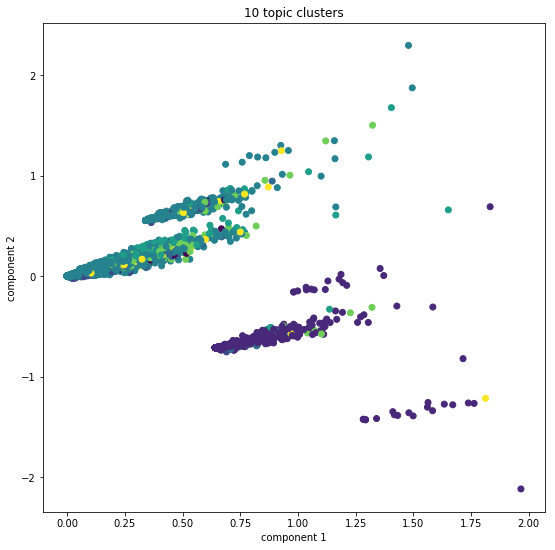

In [22]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=10, random_state=100).fit_predict(train_data_vectorized)

svd_model = TruncatedSVD(n_components=2)
lda_output_svd = svd_model.fit_transform(train_data_vectorized)

x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

print("component's weights: ", (svd_model.components_, 2))
print('% of variance explained: ', (svd_model.explained_variance_ratio_, 2))

plt.figure(figsize=(9, 9))
plt.scatter(x, y, c=clusters)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('10 topic clusters')
plt.show()

component's weights:  (array([[ 0.00376779,  0.00312138,  0.01477541, ...,  0.0058858 ,
         0.00157078,  0.00237571],
       [-0.00052683,  0.00345712,  0.00887026, ...,  0.00333307,
         0.00147003,  0.00048678]]), 2)
% of variance explained:  (array([0.01187829, 0.01274833]), 2)


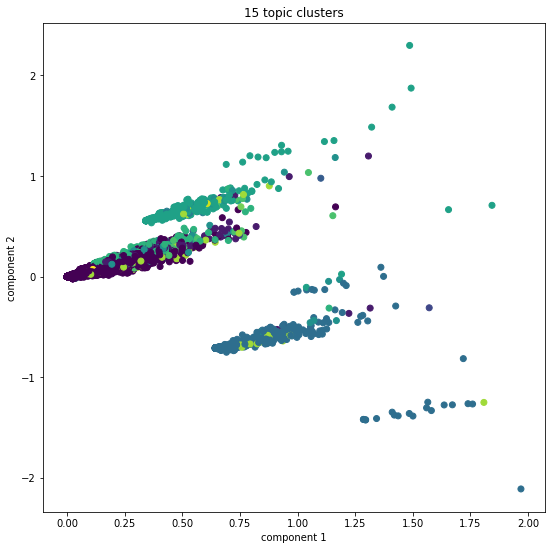

In [23]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(train_data_vectorized)

svd_model = TruncatedSVD(n_components=2)
lda_output_svd = svd_model.fit_transform(train_data_vectorized)

x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

print("component's weights: ", (svd_model.components_, 2))
print('% of variance explained: ', (svd_model.explained_variance_ratio_, 2))

plt.figure(figsize=(9, 9))
plt.scatter(x, y, c=clusters)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('15 topic clusters')
plt.show()

# use n_clusters of 10, 15, and/or 20 to see if clusters are stable and consistent 

component's weights:  (array([[ 0.00377105,  0.00312316,  0.01478416, ...,  0.00586494,
         0.00157021,  0.00238282],
       [-0.00055168,  0.00341274,  0.00879242, ...,  0.00327271,
         0.00156594,  0.00052797]]), 2)
% of variance explained:  (array([0.01187171, 0.0127312 ]), 2)


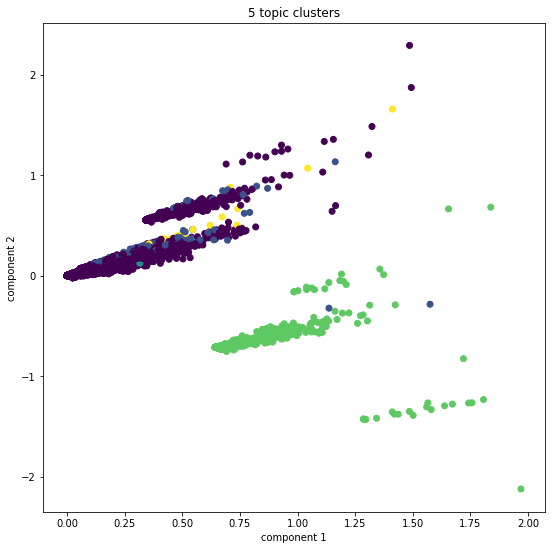

In [24]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=5, random_state=100).fit_predict(train_data_vectorized)

svd_model = TruncatedSVD(n_components=2)
lda_output_svd = svd_model.fit_transform(train_data_vectorized)

x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

print("component's weights: ", (svd_model.components_, 2))
print('% of variance explained: ', (svd_model.explained_variance_ratio_, 2))

plt.figure(figsize=(9, 9))
plt.scatter(x, y, c=clusters)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('5 topic clusters')
plt.show()

# use n_clusters of 10, 15, and/or 20 to see if clusters are stable and consistent 

In [25]:
# next is mlp

# mlp for tfidf

vectorizer = TfidfVectorizer(max_df=0.5,
                            min_df=2,
                            stop_words='english',
                            lowercase=True,
                            use_idf=True,
                            norm=u'l2',
                            smooth_idf=True,
                            ngram_range=(1, 3)
                            )
X_train = vectorizer.fit_transform(train[0].astype(str))
Y_train = train[1]


X_test = vectorizer.fit_transform(test[0].astype(str))
Y_test = test[1]

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100,), max_iter=500, activation='logistic')
mlp.fit(X_train, Y_train)
print(mlp.score(X_train, Y_train))



0.92018779342723


In [26]:
# not sure exactly what is up with X_test and Y_test and error - print(mlp.score(X_test, Y_test))
#ValueError: dimension mismatch
# so gonna do cross_val_score instead

from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X_train, Y_train, cv=5)

array([0.62390029, 0.59457478, 0.6085044 , 0.6226138 , 0.60866373])

In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X_test, Y_test, cv=5)

# how to change mlp to improve scores?

array([0.57894737, 0.59237537, 0.53372434, 0.55718475, 0.52058824])

In [28]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer

X_train = vectorizer.fit_transform(train[0].astype(str))

terms = vectorizer.get_feature_names()

ntopics=10

def word_topic(tfidf, solution, wordlist):
    words_by_topic = tfidf.T * solution
    components = pd.DataFrame(words_by_topic, index=wordlist)
    return components

def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index = np.repeat(n_topics, n_top_words, axis=0)
    topwords = pd.Series(index=index)
    for column in range(components.shape[1]):
        sortedwords = components.iloc[:,column].sort_values(ascending=False)
        chosen=sortedwords[:n_top_words]
        chosenlist = chosen.index + ' '+round(chosen, 2).map(str)
        topwords.loc[column] = chosenlist
    return(topwords)

n_top_words = 10

In [30]:
# LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train)

components_lsa = word_topic(X_train, X_train_lsa, terms)

topwords = pd.DataFrame()
topwords['LSA'] = top_words(components_lsa, n_top_words)

In [31]:
# LDA 
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

X_train_lda = lda.fit_transform(X_train)

components_lda = word_topic(X_train, X_train_lda, terms)

topwords['LDA'] = top_words(components_lda, n_top_words)

In [32]:
from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

X_train_nmf = nmf.fit_transform(X_train)

components_nmf = word_topic(X_train, X_train_nmf, terms)

topwords['NMF'] = top_words(components_nmf, n_top_words)

In [33]:
for topic in range(ntopics):
    print('topic {}:'.format(topic))
    print(topwords.loc[topic])

topic 0:
            LSA          LDA             NMF
0   said 103.95    said 9.52      said 19.58
0  husband 7.91    time 8.38  said said 0.48
0       oh 7.09   years 6.44        yes 0.47
0     time 7.05    like 6.17       time 0.44
0    night 6.54    felt 6.01        need 0.4
0     need 6.38     love 5.9    husband 0.34
0   wanted 6.36     got 5.52       want 0.34
0      yes 6.24    says 4.93    finally 0.34
0    think 6.19     did 4.92        don 0.32
0     want 6.04  mother 4.58      leave 0.31
topic 1:
             LSA          LDA             NMF
1     love 35.43    said 7.43       didn 5.13
1     didn 30.19    went 6.55       know 3.39
1     like 22.92    like 6.54  didn know 1.15
1      want 20.5    didn 6.46  didn want 0.85
1      say 20.31    tell 6.02       want 0.81
1     life 19.92    love 5.78   don know 0.49
1     know 19.36    time 5.55        don 0.41
1   people 18.47   thing 4.64        say 0.38
1      way 18.33  looking 4.6       said 0.28
1  husband 17.74  things 4.

# Conclusions

Topic modeling has many different approaches and even some awesome visuals like word clouds (not shown here). Topic modeling and NLP are a tough branch of study much more work could be done here to explore topics of love and what "modern"means in Modern Love.

In this study, LSA and NMF had similar words for many of the 10 topics. Based on word loading of LSA, LDA, and NMF (also not shown), LDA and NMF make a little more sense because they have positive values.

K-means here does not work very well, may be due to non-uniformity.

### Next steps

To continue working on topic modeling, I think it would be interesting to see how the models split the topics into groups. The articles here are about love of a spouse/girlfriend/boyfriend, relationships, family dynamics, loss of loved one, love of parent. Many many topics. They could be split in different way and further exploration may lead to some interesting insights as well as how these topics change over time to answer what is "Modern"?. 